<a href="https://colab.research.google.com/github/Siri-cod/LLMcourse/blob/main/homework/Qian_Xinrui_HW2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Homework 2: Fine-tuning & Prompting of LMs (51 points)

The focus of this homework is on one prominent fine-tuning technique -- reinforcement learning from human feedback -- and on critically thinking about prompting techniques and papers about language models

### Logistics

* submission deadline: June 3rd th 23:59 German time via Moodle
  * please upload a **SINGLE .IPYNB FILE named Surname_FirstName_HW2.ipynb** containing your solutions of the homework.
* please solve and submit the homework **individually**!
* if you use Colab, to speed up the execution of the code on Colab, you can use the available GPU (if Colab resources allow). For that, before executing your code, navigate to Runtime > Change runtime type > GPU > Save.


## Exercise 1: Advanced prompting strategies (16 points)

The lecture discussed various sophisticated ways of prompting language models for generating texts. Please answer the following questions about prompting techniques in context of different models, and write down your answers, briefly explaining them (max. 3 sentences). Feel free to actually try out some of the prompting strategies to play around with them and build your intuitions.

> Consider the following language models:
> * GPT-4, Qwen-2.5-Coder-32B, Mistral-24B-Instruct, Llama-2-70b-base.
>  
> Consider the following prompting / generation strategies:
> * tree-of-thought reasoning, zero-shot chain-of-thought prompting, few-shot prompting, self-reflection prompting.
>
> For each model:
> * which strategies do you think work well, and why?
>
> For each prompting strategy:
> * Name an example task or context, and model, in which you would think they work best. Briefly justify why.

Answer:

1.For each model,

* GPT-4 : GPT-4 performs well across all four strategies. It handles tree-of-thought and self-reflection especially well, generating multiple reasoning paths and revising its outputs. Few-shot and zero-shot CoT also work reliably.

* Qwen-2.5-Coder-32B : Qwen excels at few-shot prompting, especially in structured tasks like code generation, but is weaker at open-ended reasoning. tree-of-thought and self-reflection require more scaffolding to work well. It benefits significantly from explicit formatting and examples.

* Mistral-24B-Instruct : Mistral handles zero-shot CoT and few-shot prompting quite well, particularly in step-by-step or instructional tasks. It can manage tree-of-thought with clear structure but struggles with deeper or abstract reasoning. Self-reflection is limited to superficial edits unless externally guided.

* Llama-2-70b-base : Llama-2 base struggles with most strategies due to its lack of instruction tuning, though it can follow few-shot prompting when examples are very clear. It performs poorly on self-reflection and open-ended reasoning like tree-of-thought or zero-shot CoT. Providing structured examples and external scaffolding significantly improves its performance.

2.For each prompting strategy,

- tree-of-thought reasoning
  - Example: Solving math word problems or logic puzzles
  - Model: GPT-4
  - Why: GPT-4 can reason over multiple solution paths and evaluate options well.

- zero-shot CoT
  - Example: Commonsense reasoning, e.g. “Where would you expect to find a pizzeria while shopping?”
  - Model: Mistral-24B-Instruct
  - Why: It can follow “Let's think step by step” prompts effectively.

- few-shot
  - Example: Code generation with specific function templates
  - Model: Qwen-2.5-Coder-32B
  - Why: It performs best when given structured, syntactically similar examples.

- self-reflection
  - Example: Rewriting incorrect logic or flawed answers
  - Model: GPT-4
  - Why: Capable of critiquing and correcting its own outputs coherently.

## Exercise 2: RLHF for summarization (15 points)

In this exercise, we want to fine-tune GPT-2 to generate human-like news summaries, following a procedure that is very similar to the example of the movie review generation from [sheet 4.1](https://cogsciprag.github.io/Understanding-LLMs-course/tutorials/04a-finetuning-RL.html). The exercise is based on the paper by [Ziegler et al. (2020)](https://arxiv.org/pdf/1909.08593).

To this end, we will use the following components:
* in order to initialize the policy, we use GPT-2 that was already fine-tuned for summarization, i.e., our SFT model is [this](https://huggingface.co/gavin124/gpt2-finetuned-cnn-summarization-v2)
* as our reward model, we will use a task-specific reward signal, namely, the ROUGE score that evaluates a summary generated by a model against a human "gold standard" summary.
* a dataset of CNN news texts and human-written summaries (for computing the rewards) for the fine-tuning which can be found [here](https://huggingface.co/datasets/abisee/cnn_dailymail). Please note that we will use the *validation* split because we only want to run short fine-tuning.

**NOTE:** for building the datset and downloading the pretrained model, ~4GB of space will be used.

> **YOUR TASK:**
>
> Your job for this task is to set up the **GRPO-based** training with the package `trl`, i.e., the set up step 3 of [this](https://cdn.openai.com/instruction-following/draft-20220126f/methods.svg) figure. GRPO (Group Relative Policy Optimization) is an RL algorithm that was proposed by [Shao et al. (2024)](https://arxiv.org/pdf/2402.03300) for the DeepSeek math model.
> 1. Please complete the code or insert comments what a particular line of code does below where the comments says "#### YOUR CODE / COMMENT HERE ####". For this and for answering the questions, you might need to dig a bit deeper into the working of GRPO, the algorithm that we are using for training. You can find relevant information on the implementation, e.g., [here](https://huggingface.co/docs/trl/main/en/grpo_trainer).
> 2. To test your implementation, you can run the training for ~250 steps, but you are NOT required to train the full model since it will take too long. We will NOT be evaluating your submission based on the performance of the model.
> 3. Answer the questions below.

In [5]:
!pip install gcsfs==2025.3.0 fsspec==2025.3.0 accelerate==1.6.0 trl==0.17.0 evaluate rouge_score datasets

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 16.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 348.0/348.0 kB 29.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.5/491.5 kB 27.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 105.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 92.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 51.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 5.6 MB/s eta 0:00:00

In [1]:
# import libraries
import torch
from tqdm import tqdm
import pandas as pd

tqdm.pandas()

from transformers import AutoTokenizer
from datasets import load_dataset

from trl import (
    GRPOTrainer,
    GRPOConfig,
)
import evaluate

In [2]:
#### YOUR COMMENT HERE (what is the purpose of this code?) ####
# Create a config object and set the configuration
config = GRPOConfig(
    #### YOUR COMMENT HERE (what is the meaning of each of the following parameters?) #####
    # Set the learning rate to 1.41e-5
    learning_rate=1.41e-5,
    #### YOUR COMMENT HERE ####
    # Set the maximum training steps to 250
    max_steps=250,
    #### YOUR COMMENT HERE ####
    # Set the number of training samples processed per device (GPU/CPU) in one forward/backward pass to 8
    per_device_train_batch_size=8,
    #### YOUR COMMENT HERE####
    # Set the number of candidate actions generated per optimization step to 8
    num_generations=8,
    #### YOUR CODE HERE: set the number of overall training epochs to 1 ####
    num_train_epochs=1,
    #### YOUR COMMENT HERE####
    # Logs are recorded after every 1 training step
    logging_steps=1,
    #### YOUR COMMENT HERE####
    # Disables reporting metrics to external platforms
    report_to="none",
)

We load the CNN dataset and truncate the texts to 512 tokens, because we don't want the training to be too memory heavy and we want to have "available" some tokens for the generation (GPT-2's context window size is 1024). Then we tokenize each text and pad it.

In [3]:
ds = load_dataset("abisee/cnn_dailymail", '1.0.0', split="validation")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/15.6k [00:00<?, ?B/s]

train-00000-of-00003.parquet:   0%|          | 0.00/256M [00:00<?, ?B/s]

train-00001-of-00003.parquet:   0%|          | 0.00/257M [00:00<?, ?B/s]

train-00002-of-00003.parquet:   0%|          | 0.00/259M [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/34.7M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/30.0M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/287113 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/13368 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/11490 [00:00<?, ? examples/s]

In [6]:
print(ds[0])

{'article': '(CNN)Share, and your gift will be multiplied. That may sound like an esoteric adage, but when Zully Broussard selflessly decided to give one of her kidneys to a stranger, her generosity paired up with big data. It resulted in six patients receiving transplants. That surprised and wowed her. "I thought I was going to help this one person who I don\'t know, but the fact that so many people can have a life extension, that\'s pretty big," Broussard told CNN affiliate KGO. She may feel guided in her generosity by a higher power. "Thanks for all the support and prayers," a comment on a Facebook page in her name read. "I know this entire journey is much bigger than all of us. I also know I\'m just the messenger." CNN cannot verify the authenticity of the page. But the power that multiplied Broussard\'s gift was data processing of genetic profiles from donor-recipient pairs. It works on a simple swapping principle but takes it to a much higher level, according to California Pacifi

In [4]:
def build_dataset(
        model_name,
        dataset_name="abisee/cnn_dailymail"
    ):
    """
    Build dataset for training. This builds the dataset from `load_dataset`.

    Args:
        model_name (`str`):
            The name of the SFT model to be used, so that the matchin tokenizer can be loaded.
        dataset_name (`str`):
            The name of the dataset to be loaded.

    Returns:
        dataloader (`torch.utils.data.DataLoader`):
            The dataloader for the dataset.
    """
    tokenizer = AutoTokenizer.from_pretrained(model_name)#### YOUR CODE HERE ####)
    tokenizer.pad_token = tokenizer.eos_token
    tokenizer.padding_side = 'left'
    # load the datasets
    ds = load_dataset(dataset_name, '1.0.0', split="validation")

    def tokenize(sample):
        sample["input_ids"] = tokenizer.encode(
            #### YOUR CODE HERE (hint: inspect the dataset to see how to access the input text)####,
            sample["article"],
            return_tensors="pt",
            max_length=512,
            truncation=True,
            padding="max_length"
        )
        # get the truncated natural language text, too
        sample["prompt"] = tokenizer.decode(sample["input_ids"][0], skip_special_tokens = True)#### YOUR CODE HERE ####
        sample["ground_truth"] = sample['highlights']#### YOUR CODE HERE ####
        return sample

    ds = ds.map(tokenize, batched=False)
    ds.set_format(type="torch")
    return ds


In [5]:
# use tokenizer from HF named: "gavin124/gpt2-finetuned-cnn-summarization-v2"
# build the dataset
dataset =  build_dataset(model_name="gavin124/gpt2-finetuned-cnn-summarization-v2")#### YOUR CODE HERE ####

def collator(data):
    return dict((key, [d[key] for d in data]) for key in data[0])

tokenizer_config.json:   0%|          | 0.00/748 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/999k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/75.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/296 [00:00<?, ?B/s]

Map:   0%|          | 0/13368 [00:00<?, ? examples/s]

In [10]:
# inspect a sample of the dataset
print(dataset[0])

{'article': '(CNN)Share, and your gift will be multiplied. That may sound like an esoteric adage, but when Zully Broussard selflessly decided to give one of her kidneys to a stranger, her generosity paired up with big data. It resulted in six patients receiving transplants. That surprised and wowed her. "I thought I was going to help this one person who I don\'t know, but the fact that so many people can have a life extension, that\'s pretty big," Broussard told CNN affiliate KGO. She may feel guided in her generosity by a higher power. "Thanks for all the support and prayers," a comment on a Facebook page in her name read. "I know this entire journey is much bigger than all of us. I also know I\'m just the messenger." CNN cannot verify the authenticity of the page. But the power that multiplied Broussard\'s gift was data processing of genetic profiles from donor-recipient pairs. It works on a simple swapping principle but takes it to a much higher level, according to California Pacifi

We load the tokenizer corresponsing to the SFT GPT2 model that we already used above to pretokenize the dataset.

In [6]:
tokenizer = AutoTokenizer.from_pretrained("gavin124/gpt2-finetuned-cnn-summarization-v2")

tokenizer.padding_side='left'
tokenizer.pad_token = tokenizer.eos_token

Below, we define our custom reward function:

In [7]:
# Run with error
rouge = evaluate.load("rouge")

def reward_fn(
        output: list[str],
        original_summary: list[str]
    ):
    """
    #### YOUR COMMENT HERE ####
    Calculate the ROUGE score between the generated summary and the original summary.

    Args:
        output (`list[str]`):
            The generated summary.
        original_summary (`list[str]`):
            The original summary.

    Returns:
        scores (`torch.Tensor`):
            The ROUGE score between the generated summary and the original summary.
    """
    scores = []
    for o, s in list(zip(output, original_summary)):
      score = rouge.compute(predictions=[o.strip()], references=[s])["rouge1"]
      scores.append(torch.tensor(score))

    return scores

In [17]:
# Run successfully
rouge = evaluate.load("rouge")

def reward_fn(
        completions: list[str],
        prompts: list[str], **kwargs
    ):
    """
    #### YOUR COMMENT HERE ####
    Calculate the ROUGE-1 score between generated completions and reference prompts.

    Args:
        completions (`list[str]`):
            The generated summary.
        prompts (`list[str]`):
            The ground truth summary.
        **kwargs:
            Additional arguments (unused in this function but kept for compatibility).

    Returns:
        scores (`torch.Tensor`):
            The ROUGE score between the generated summary and the original summary.
    """
    scores = []
    for o, s in list(zip(completions, prompts)):
      score = rouge.compute(predictions=[o.strip()], references=[s])["rouge1"]
      scores.append(torch.tensor(score))

    return scores

Nest, we set up the trainer:

In [18]:
#### YOUR COMMENTS BELOW (what are the congle lines doing?) ####
grpo_trainer = GRPOTrainer(
    # Pass the config object defined above
    args=config,
    # Load the fine-tuned model "gavin124/gpt2-finetuned-cnn-summarization-v2"
    model="gavin124/gpt2-finetuned-cnn-summarization-v2",
    # Set the reward function to reward_fn defined above
    reward_funcs=reward_fn,
    # Provide the tokenizer to handle text processing
    processing_class=tokenizer,
    # Set the training dataset to dataset built above
    train_dataset=dataset,
)

In [ ]:
grpo_trainer.train()

Step,Training Loss
1,-0.257500
2,-0.483700
3,0.004300
4,0.020300
5,-0.252500
6,-0.032800
7,0.005400
8,-0.338200
9,-0.274700
10,-0.071100


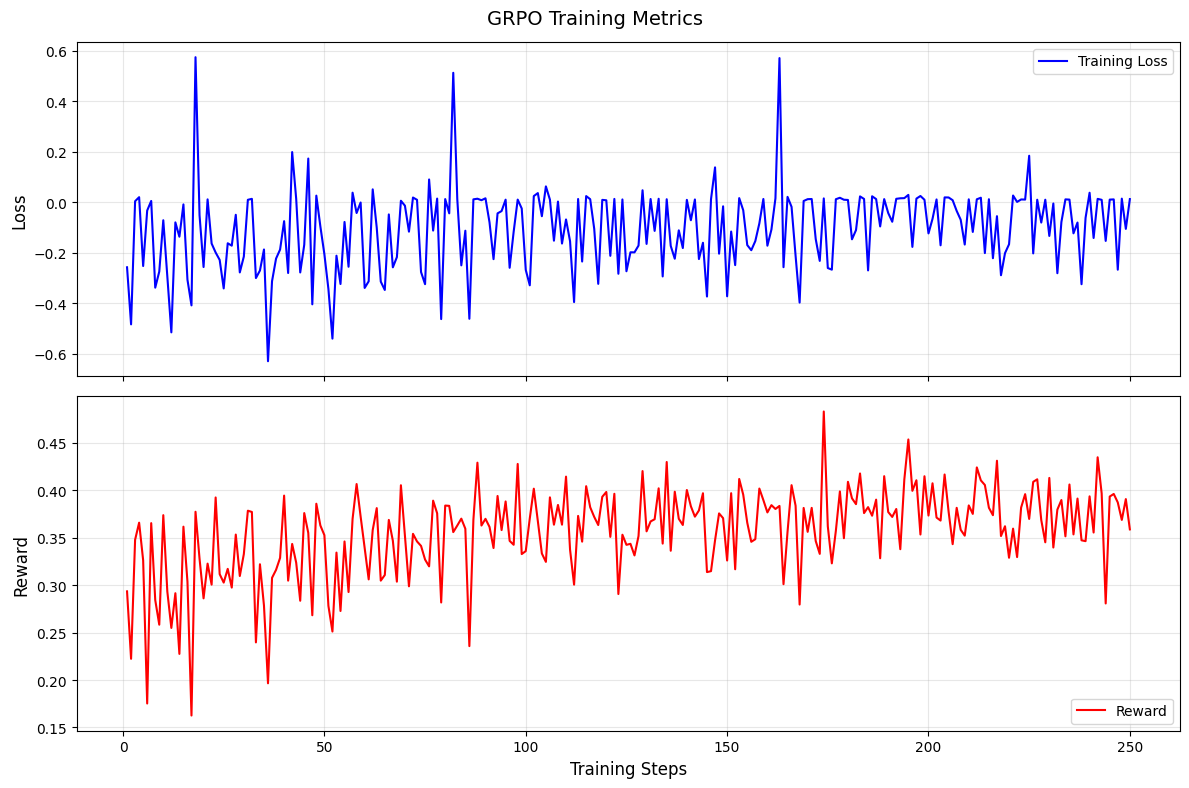

In [10]:
#### YOUR CODE HERE: plot the loss and the rewards of the model training by accessing the trainer logs under grpo_trainer.state.log_history ####
import matplotlib.pyplot as plt
import numpy as np

# Extract logs from trainer
logs = grpo_trainer.state.log_history

# Prepare data containers
steps, losses, rewards = [], [], []

# Parse log_history (structure depends on GRPO implementation)
for log in logs:
    if "loss" in log:
        steps.append(log.get("step", len(steps)))
        losses.append(log["loss"])
    if "reward" in log:
        rewards.append(log["reward"])

# Handle cases where rewards are logged less frequently
if len(rewards) < len(losses):
    rewards = rewards + [None]*(len(losses)-len(rewards))

# Create plot
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8), sharex=True)

# Plot Loss
ax1.plot(steps, losses, 'b-', label="Training Loss")
ax1.set_ylabel("Loss", fontsize=12)
ax1.legend(loc="upper right")
ax1.grid(True, alpha=0.3)

# Plot Reward
ax2.plot(steps[:len(rewards)], rewards, 'r-', label="Reward")
ax2.set_xlabel("Training Steps", fontsize=12)
ax2.set_ylabel("Reward", fontsize=12)
ax2.legend(loc="lower right")
ax2.grid(True, alpha=0.3)

plt.suptitle("GRPO Training Metrics", fontsize=14)
plt.tight_layout()
plt.show()
#### YOUR COMMENT HERE: do the plots indicate a trend towards successful training? ####
# Yes, the reward plot indicate a trend towards successful training. The rewards increase as the training steps increase.
# But the loss plot doesn't show a decrease trend as the training steps increase.


> **QUESTIONS:**
>
> 1. Suppose the plots of rewards below show training metrics for different runs of the summarization model training. Interpret what each of the plots tells us about training success; i.e., did the training run go well on this run? Do we expect to get good summaries? Why? Be concise!
> 2. We have truncated the query articles to maximally 512 tokens. Given that we are using ROUGE with respect to ground truth summaries as a reward, why might this be problematic?
> 3. GRPO is an algorithm improving over the PPO algorithm (Proximal Policy Optimization). What is they aspect that helps improve over PPO? Explain briefly.
> 4. In the GRPO paper referenced above, on page 14, you can find the pseudo-algorithm for GRPO. For lines  1--4, 7--8 of the pseudo-code, write down what in our code above instatiates the concepts in the pseudo-code.
> 5. In your own words, explain intuititvely what the role of the *group* in the algorithm is and why it is used. Use max. 3 sentences.
> 6.  Name the parameter in the code above that determines the group size.

Answer:

1. For A, the trend of rewards keeps stable, which means the scores doesn't change much as the steps increase. So the training run doesn't go well.
For B, the rewards decrease as the steps increase. It indicates that the training run goes worse and worse.
For C, the rewards increase rapidly first and then become stable at approximately 1 as the steps increase. It shows that the training run goes well because the score should be 1 when the summary is generated well.

2. Truncation may remove key content needed to generate summaries matching the original reference so that the scores will be not accurate. And the model may learn to prioritize early article content (which it always sees) over later content (which may be truncated).

3. GRPO introduces a gradient penalty term to constrain updates, preventing overly large changes to the policy. GRPO dynamically adjusts the trust region (which is fixed in PPO) based on Gradient magnitudes and Reward consistency.

4. * Line 1: model="gavin124/gpt2-finetuned-cnn-summarization-v2" in GRPOTrainer initializes πθ
  * Line 2: num_train_epochs=1
  * Line 3: model="gavin124/gpt2-finetuned-cnn-summarization-v2"
  * Line 4: max_steps=250
  * Line 7: GRPOTrainer(reward_funcs=reward_fn); batch_size = 8
  * Line 8: reward_fn computes ROUGE scores against reference summaries (original_summary), serving as rφ

5. The group in GRPO helps stabilize training by comparing multiple generated outputs (a "group") for the same input, allowing the algorithm to relativize rewards reducing sensitivity to reward scale/noise and estimate advantage more robustly by analyzing intra-group performance differences, which improves policy updates.

6. num_generations

![img](https://github.com/CogSciPrag/Understanding-LLMs-course/blob/main/understanding-llms/homework/data/rewards.png?raw=1)

## Exercise 3: First neural LM (20 points)

Next to reading and understanding package documentations, a key skill for NLP researchers and practitioners is reading and critically assessing NLP literature. The density, but also the style of NLP literature has undergone a significant shift in the recent years with increasing acceleration of progress. Your task in this exercise is to read a paper about one of the first successful neural langauge models, understand its key architectural components and compare how these key components have evolved in modern systems that were discussed in the lecture.

> Specifically, please read the paper by [Bengio et al. (2003)](https://www.jmlr.org/papers/volume3/bengio03a/bengio03a.pdf) and answer the following questions:
>
> * How were words / tokens represented? What is the difference / similarity to modern LLMs?
> * How was the context represented? What is the difference / similarity to modern LLMs?
> * What is the curse of dimensionality? Give a concrete example in the context of language modeling.
> * Which training data was used? What is the difference / similarity to modern LLMs?
> * Which components of the Bengio et al. (2003) model (if any) can be found in modern LMs?
>

Furthermore, your task is to carefully dissect the paper by Bengio et al. (2003) and analyse its structure and style in comparison to another more recent paper:  [Devlin et al. (2019) BERT: Pre-training of Deep Bidirectional Transformers for Language Understanding](https://arxiv.org/pdf/1810.04805)

**TASK:**

> For each section of the Bengio et al. (2003) paper, what are key differences between the way it is written, the included contents, to the BERT paper (Devlin et al., 2019)? What are key similarities? Write max. 2 sentences per section.


Answer:

- How were words / tokens represented? What is the difference / similarity to modern LLMs?
  - Bengio (2003): Words were represented as dense, continuous vectors (embeddings) learned via a neural network.
  - Modern LLMs: Similarly use embeddings, but with much larger dimensions (e.g., 4096-dim in GPT-4 vs. ~30-dim in Bengio) and subword tokenization (e.g., Byte-Pair Encoding).
- How was the context represented? What is the difference / similarity to modern LLMs?
  - Fixed-length concatenated embeddings of previous words (n-gram style), processed by a feedforward network.
  - Use self-attention (Transformers) to dynamically weigh all tokens in variable-length contexts.
- What is the curse of dimensionality?
  - Definition: Statistical sparsity in high-dimensional spaces.
  - Example: A 10-word vocabulary with 5-grams has $10^5$ combinations. Most never appear in training, making probability estimation unreliable.
- Which training data was used? What is the difference / similarity to modern LLMs?
  - Small corpora (e.g., Brown Corpus, ~1M words), domain-specific
  - Web-scale data (e.g., Common Crawl, trillions of tokens), often filtered for quality.
- Which components of the Bengio et al. (2003) model (if any) can be found in modern LMs?
  - Neural Network Parametrization
  - Word Embeddings
  - Probabilistic Language Modeling
  - Hidden Layers for Feature Extraction
  - Training via Backpropagation
  - Activation functions (Softmax, ReLU, ...)

Answer for Task:
1. Abstract
- Bengio (2003): Focuses on theoretical novelty (neural LMs vs. n-grams) and the curse of dimensionality.
- BERT (2019): Emphasizes empirical results (SOTA benchmarks) and bidirectional pretraining.

2. Introduction
- Bengio (2003): Motivates neural LMs as a solution to data sparsity, with mathematical intuition.
- BERT (2019): Positions BERT as a general-purpose solution, citing limitations of unidirectional LMs (e.g., GPT).

3. Related Work
- Bengio (2003): Compares to statistical methods (n-grams, HMMs) and early neural approaches.
- BERT (2019): Surveys Transformer-based models (GPT, ELMo) and transfer learning trends.

4. Model Architecture
- Bengio (2003): Describes a simple feedforward net with embeddings and one hidden layer.
- BERT (2019): Details Transformer encoder layers, attention heads, and layer normalization.

5. Training
- Bengio (2003): Uses small corpora (Brown Corpus) and basic backpropagation.
- BERT (2019): Leverages massive datasets (BooksCorpus + Wikipedia) and masked LM objectives.

6. Experiments
- Bengio (2003): Evaluates via perplexity, comparing to n-grams/HMMs.
- BERT (2019): Tests on GLUE/SQuAD, emphasizing task-agnostic fine-tuning.

7. Discussion/Conclusion
- Bengio (2003): Highlights theoretical contributions (e.g., distributed representations).
- BERT (2019): Focuses on scalability and future directions (e.g., larger models).